## Attacking MNIST Dataset

Here we use a custom NN trained on MNIST data to perform *zero order Stochastic Gradient Descent*

**1. Set current directory**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/Colab Notebooks/AdvAttack

/content/gdrive/My Drive/Colab Notebooks/AdvAttack


**2. Import libraries**

In [0]:
import src.loss as customLoss
import src.ZOOptim as ZOOptim
import src.dataset as data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import math


import torch
from src.models import MnistNet
from torchvision import transforms
from torch import nn, optim

**3. Retrieve MNIST data**

We retrieve the MNIST data. <br>
The 'standard' *trasnform.compose* method just convert the data to *torch.Tensor* without any rescaling or normalizzation


Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([250, 1, 28, 28])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([250])


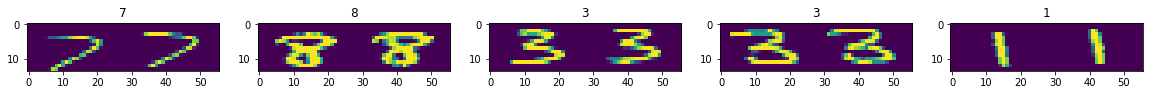

In [5]:
DataLoader = data.MNIST(transform='standard')
train, test = DataLoader.get_dataloader(batch_size=250, num_workers=0)
DataLoader.get_info()

**4. Retrieve the network**

In [6]:
device = torch.device('cuda')
net = MnistNet().to(device)
net.load_state_dict(torch.load('models/mnistBaseV2_state_dict.pth'))

<All keys matched successfully>

### MAIN
**5. ADVERSARIAL ATTACK**

Here we try to start with a random rightfully classified image from the validation set and we try to use *Zero-order Stochastic Coordinate descent with Coordinate-wise ADAM/Newton* to modify the image in order to make the network be mistaken.

We can choose whetever to use ADAM or Newton's Method by setting the solver parameter

**Args:**


    Name                    Type                Description
    x:                      (torch.tensor)      The variable of our optimization problem
    c:                      (float)             Loss weight
    learning_rate:          (float)             Learning rate
    n_gradient:             (int)               Coordinates we simultaneously optimize
    h:                      (float)             Gradient estimation accuracy O(h^2)
    beta_1:                 (float)             ADAM hyper-parameter
    beta_2:                 (float)             ADAM hyper-parameter
    solver:                 (str)               Either "ADAM" or "Newton"
    epsilon:                (float)             Avoid dividing by 0
    max_steps:              (int)               The maximum number of steps
    stop_criterion:         (boolean)           If true stop when the loss is 0
    verbose:                (int)               Display information. Default is 0
    tqdm_disable:           (bool)              Disable the tqdm bar. Default is False
    additional_out:         (bool)              Return also all the x. Default is False

**Suggested values** <br>
*ZOO: Zeroth Order Optimization Based Black-box Attacks to
Deep Neural Networks without Training Substitute Models* (Chen, Zhang et al.):

* learning_rate = 0.001 
* batch_size = 128
* h = 0.0001
* beta_1 = 0.9
* beta_2 = 0.999
* solver = "adam"
* max_iterations = 10000

All this parameters are initialized by default.



**Display an example image** <br>

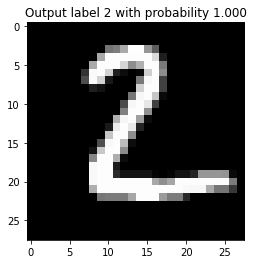

In [9]:
for batch in test:
    X, y = batch[0].to(device), batch[1].to(device)
    break
    
net.eval()
img_orig = X[1].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[1].reshape(1, 1, 28, 28)))
plt.imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig).item()
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out_orig[0, original_label])))
plt.show()

**5.2 General attack**

Here we try to manipulate the input such that it will be misclassified in favor of a whatever class. Usually its easier and we deal with the problem by minimizing the probability of the true class  

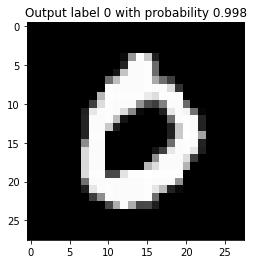

In [25]:
# 1. Choose image
index = 3

# 2. Define params
solver = "adam"
#solver = "newton"
params = {'x': X[index], 'c': 0.5, 'learning_rate': 1e-2, 
          'n_gradients': 128, 'solver': solver, 'max_steps': 1000, 
          'verbose': 0, 'stop_criterion': True, 'additional_out': True}

# 3. Display choosen image
net.eval()
img_orig = X[index].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[index].reshape(1, 1, 28, 28)))
plt.imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig).item()
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out_orig[0, original_label])))
plt.show()

  8%|▊         | 79/1000 [00:01<00:18, 49.01it/s]

First valid image found at iteration 69 with l2-distance = 1.6859886646270752


  9%|▉         | 94/1000 [00:01<00:18, 48.83it/s]


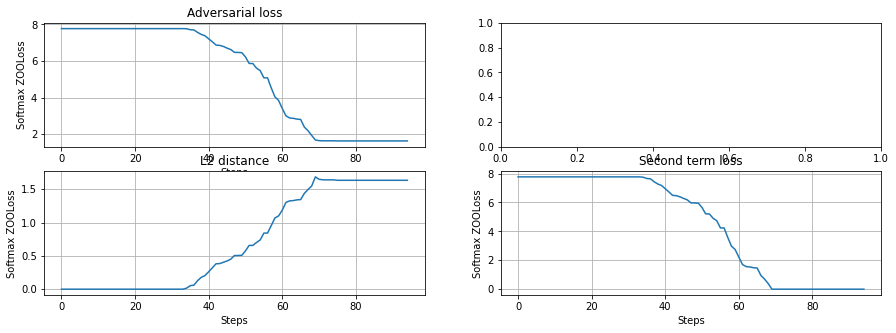

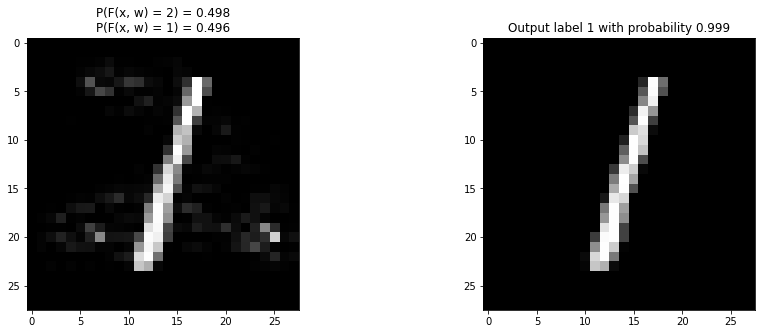

In [65]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=original_label, maximise=0, is_softmax=False, dim=1)
adv_optimizer = ZOOptim.ZOOptim(model=net, loss=adv_loss, device='cuda')

### Run the optimizer
x, loss, l2_dist, losses_st, outs = adv_optimizer.run(params)

### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, 1, 28, 28)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
# Adversarial Loss
ax[0,0].plot(loss)
ax[0,0].set_title('Adversarial loss')
ax[0,0].set_ylabel('Adversarial loss')
ax[0,0].set_xlabel('Steps')
ax[0,0].grid()
# L2 distance
ax[1,0].plot(l2_dist)
ax[1,0].set_title('L2 distance')
ax[1,0].set_ylabel('L2_dist')
ax[1,0].set_xlabel('Steps')
ax[1,0].grid()
# Second loss term
ax[1,1].plot(losses_st)
ax[1,1].set_title('Second term loss')
ax[1,1].set_ylabel('Softmax ZOOLoss')
ax[1,1].set_xlabel('Steps')
ax[1,1].grid()
plt.show

### Display adversarial example and original image
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Adversarial example
ax[0].imshow(img.reshape(28, 28), cmap='gray')
ax[0].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(label, 
                                                                            float(out[0, label]),
                                                                            original_label, 
                                                                            float(out[0, original_label])))
# Original image
ax[1].imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig)
ax[1].set_title('Output label {} with probability {:.3f}'.format(original_label, 
                                                                 float(out_orig[0, original_label])))
plt.show()

**5.1 Specific attack**

Here we try to manipulate the input such that it will be misclassified in favor of a *specific* class.

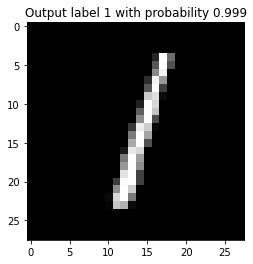

In [59]:
# 1. Choose image
index = 3

# 2. Define params
desired_ouput = 2
solver = "adam"
#solver = "newton"
params = {'x': X[index], 'c': 0.5, 'learning_rate': 1e-2, 
          'n_gradients': 128, 'solver': solver, 'max_steps': 1000, 
          'verbose': 0, 'stop_criterion': True, 'additional_out': True}

# 3. Display choosen image
net.eval()
img_orig = X[index].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[index].reshape(1, *list(img.shape))))
plt.imshow(np.transpose(img_orig, (1, 2, 0)))
original_label = torch.argmax(out_orig).item()
plt.title('Output "{}"({}) with probability {:.3f}'.format(DataLoader.classes[original_label], original_label,
                                                           float(out_orig[0, original_label])))
plt.show()

 16%|█▌        | 78/500 [00:01<00:07, 57.96it/s]

First valid image found at iteration 68 with l2-distance = 1.5851593017578125


 23%|██▎       | 114/500 [00:02<00:06, 55.33it/s]


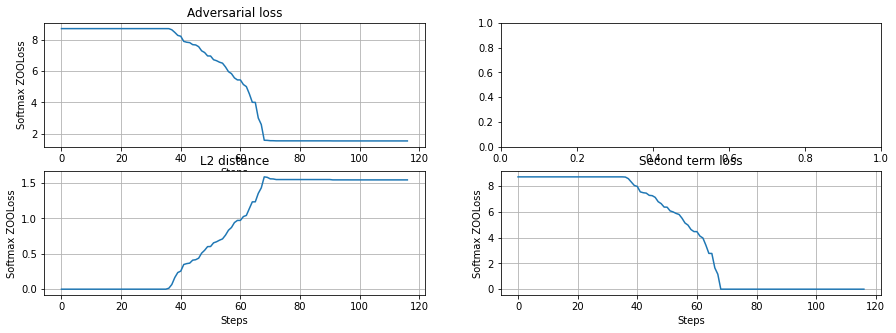

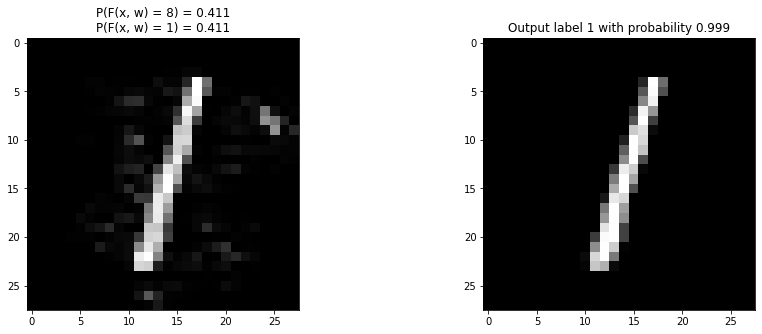

In [64]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=desired_output, maximise=1, is_softmax=False, dim=1)
adv_optimizer = ZOOptim.ZOOptim(model=net, loss=adv_loss, device='cuda')

### Run the optimizer
x, loss, l2_dist, losses_st, outs = adv_optimizer.run(params)

### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, 1, 28, 28)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
# Adversarial Loss
ax[0,0].plot(loss)
ax[0,0].set_title('Adversarial loss')
ax[0,0].set_ylabel('Adversarial loss')
ax[0,0].set_xlabel('Steps')
ax[0,0].grid()
# L2 distance
ax[1,0].plot(l2_dist)
ax[1,0].set_title('L2 distance')
ax[1,0].set_ylabel('L2_dist')
ax[1,0].set_xlabel('Steps')
ax[1,0].grid()
# Second loss term
ax[1,1].plot(losses_st)
ax[1,1].set_title('Second term loss')
ax[1,1].set_ylabel('Softmax ZOOLoss')
ax[1,1].set_xlabel('Steps')
ax[1,1].grid()
plt.show

### Display adversarial example and original image
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Adversarial example
ax[0].imshow(img.reshape(28, 28), cmap='gray')
ax[0].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(label, 
                                                                            float(out[0, label]),
                                                                            original_label, 
                                                                            float(out[0, original_label])))
# Original image
ax[1].imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig)
ax[1].set_title('Output label {} with probability {:.3f}'.format(original_label, 
                                                                 float(out_orig[0, original_label])))
plt.show()

tensor([[[0.0770, 0.0784, 0.0697, 0.0737, 0.0849, 0.0792, 0.0698, 0.0726,
          0.0724, 0.0707, 0.0729, 0.0826, 0.0790, 0.0758, 0.0845, 0.0824,
          0.0761, 0.0750, 0.0697, 0.0845, 0.0712, 0.0733, 0.0760, 0.0774,
          0.0869, 0.0754, 0.0723, 0.0778],
         [0.0659, 0.0722, 0.0810, 0.0787, 0.0810, 0.0807, 0.0757, 0.0856,
          0.0795, 0.0753, 0.0892, 0.0778, 0.0813, 0.0787, 0.0970, 0.0780,
          0.0764, 0.0825, 0.0851, 0.0829, 0.0833, 0.0846, 0.0825, 0.0735,
          0.0759, 0.0807, 0.0739, 0.0815],
         [0.0754, 0.0777, 0.0783, 0.0773, 0.0734, 0.0832, 0.0704, 0.0917,
          0.0787, 0.0791, 0.0786, 0.0817, 0.0835, 0.0834, 0.0779, 0.1002,
          0.0883, 0.0778, 0.0837, 0.0799, 0.0779, 0.0806, 0.0835, 0.0772,
          0.0812, 0.0811, 0.0764, 0.0836],
         [0.0775, 0.0791, 0.0810, 0.0719, 0.0798, 0.0787, 0.0870, 0.1055,
          0.1025, 0.1016, 0.1086, 0.0964, 0.1043, 0.0912, 0.1418, 0.1412,
          0.1618, 0.1545, 0.1228, 0.0868, 0.0851, 0.0748,

**Success rate at different infinity norm upper bound**

Here we can see how the algorithm perform when it goes from stricter to less strict epsilon with the first 10 validation images.

**BETTER ON COLAB**

In [0]:
device = torch.device('cuda')
EPOCH = 100
def evaluate(n_iter, n=7, mk=28**2, ak=0.8, v=0.2):
    X_test = X[:n, ...]
    success = []
    xs = []
    for x in tqdm(X_test):
        y_before = int(torch.argmax(net(x.to(device).view(1, 1, 28, 28))))
        loss = customLoss.ZooLoss(neuron=y_before, maximise=0, dim=1)
        ADVoptim = ZOOptimizer(model=net, loss=loss, device=device)
        x_out, loss_curve, out =  ADVoptim.run(x, 
                                               c               =  0.4,
                                               learning_rate = 0.1,
                                               verbose         =  0,
                                               max_iterations = n_iter,
                                               additional_out  =  False)

        if int(torch.argmax(net(x_out.reshape(1, 1, 28, 28))).item()) != y_before:
            success.append(1)
        else:
            success.append(0)
        xs.append(x_out)
    return success, xs

net = net.to(device)
n_iter = 600
success_list, out_list = evaluate(n_iter, ak=0.9)
print('Success rate:\t{:.1f}%'.format(100*np.sum(success_list)/len(success_list)))

100%|██████████| 7/7 [00:35<00:00,  5.14s/it]

Success rate:	100.0%


100%|██████████| 7/7 [00:31<00:00,  4.43s/it]


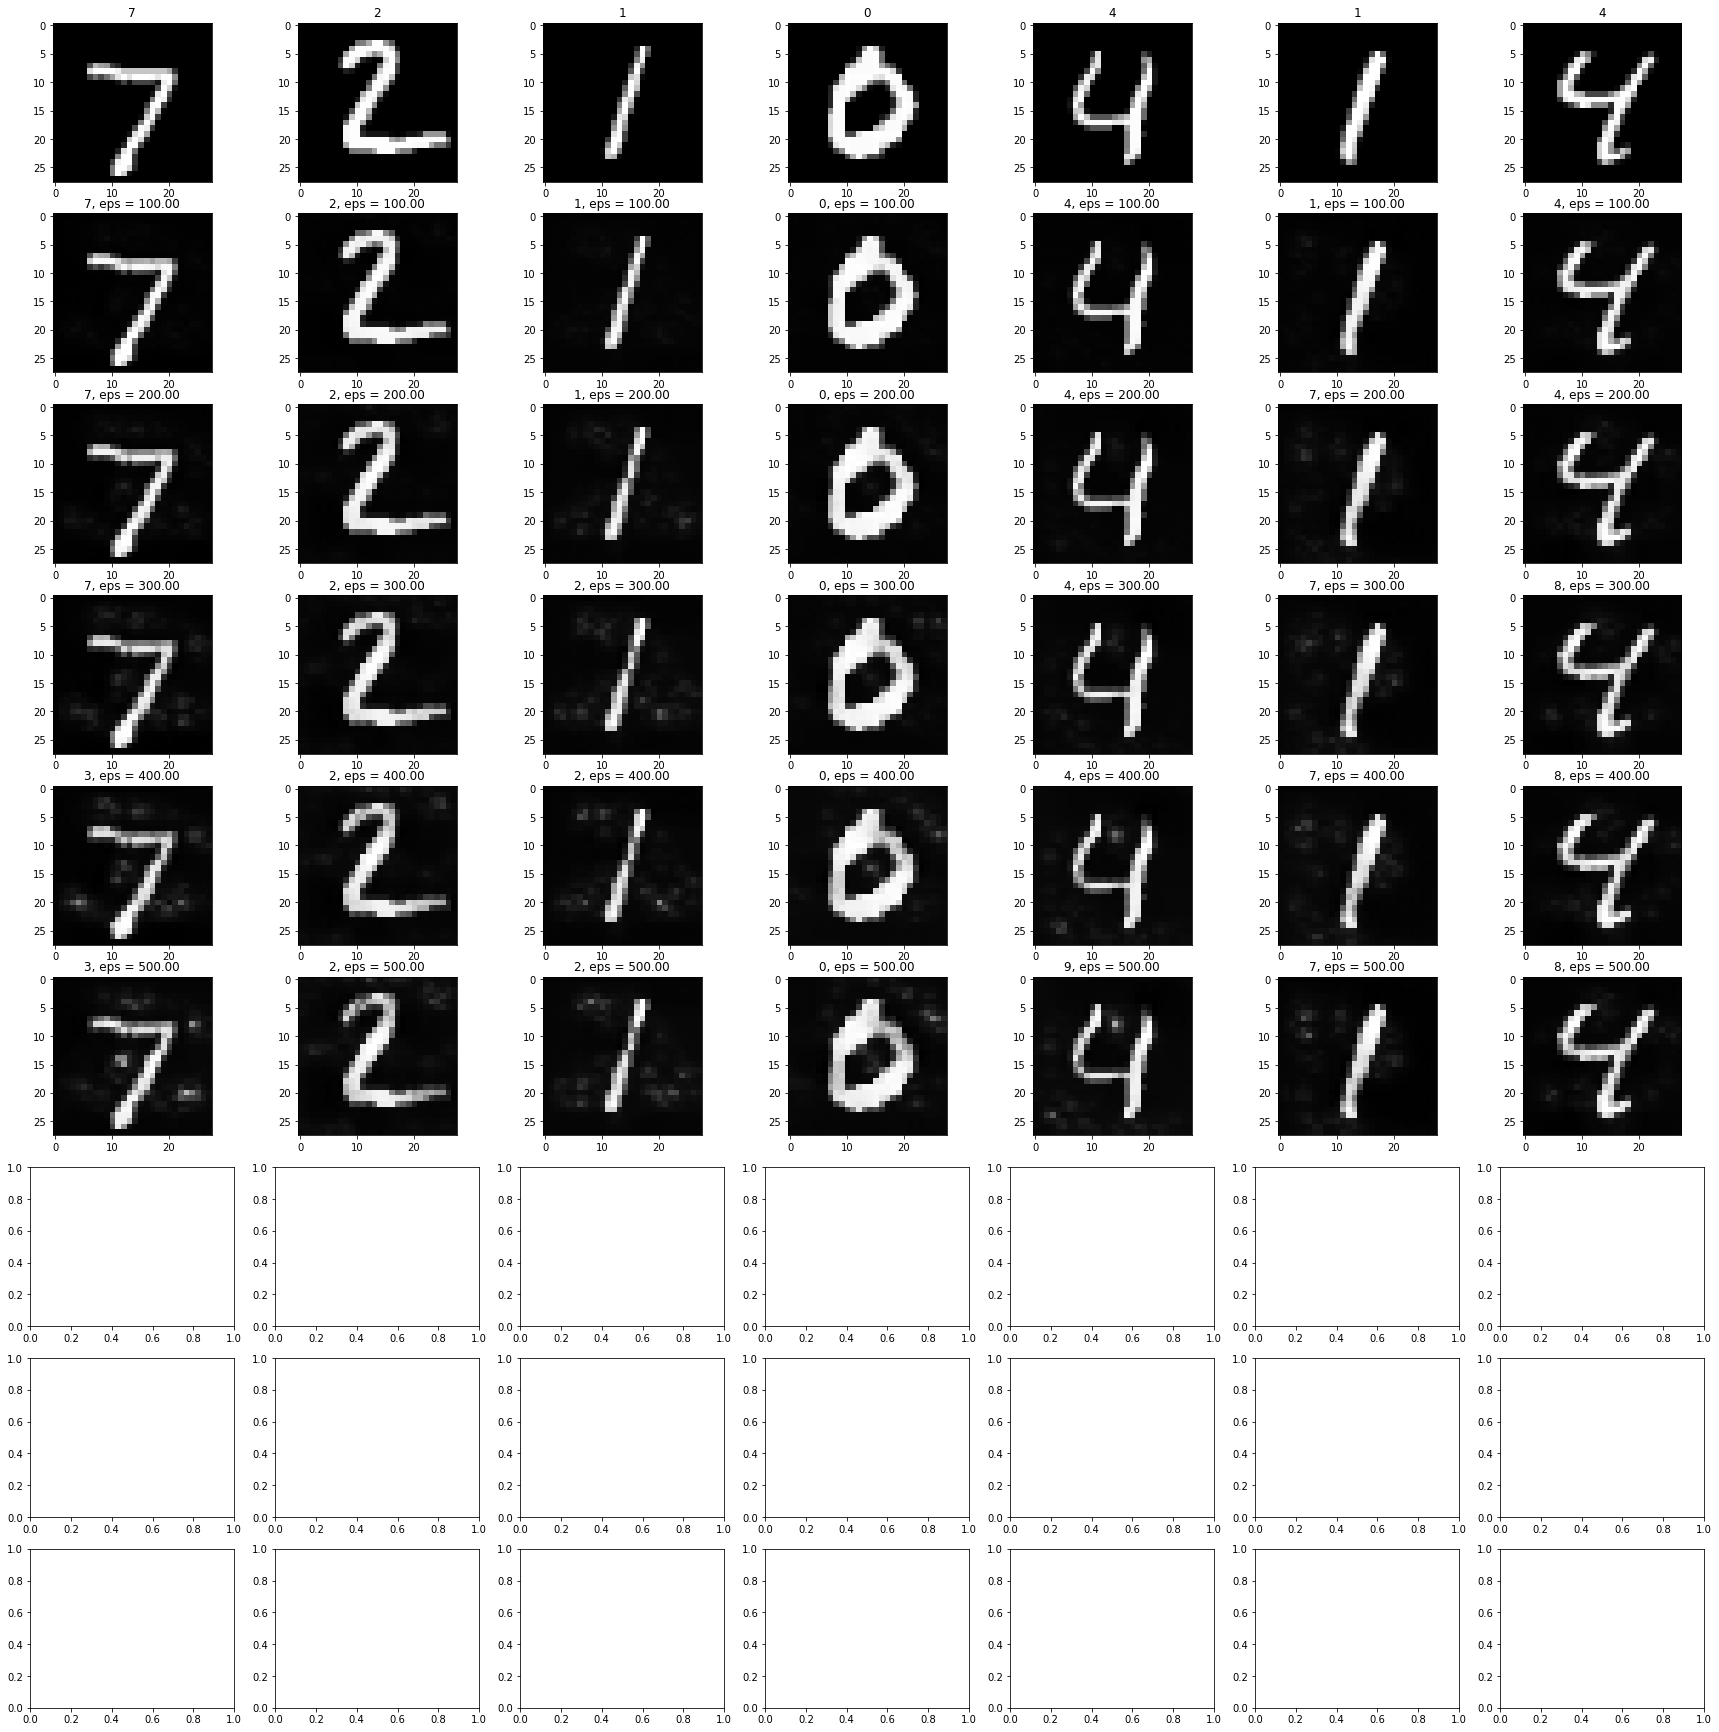

In [0]:
fig, ax = plt.subplots(9, 7, figsize = (30, 31))
for n in range(7):
    out_before = int(torch.argmax(net(X[n, ...].to(device).view(1, 1, 28, 28))))
    img_before = X[n, ...].detach().cpu().numpy()
    ax[0, n].imshow(img_before.reshape(28, 28), cmap='gray')
    ax[0, n].set_title(out_before)
for i in range(1,6):
    a1, b1 = evaluate(i*100)
    for n, t in enumerate(zip(a1, b1)):
        out_after = int(torch.argmax(net(t[1].view(1, 1, 28, 28))))
        img_after = t[1].detach().cpu().numpy()
        ax[i, n].imshow(img_after.reshape(28, 28), cmap='gray')
        ax[i, n].set_title('{}, iterations = {:.2f}'.format(out_after, float(i*100)))
plt.show()